In [1]:
import pandas as pd
import numpy as np
# Importing airquality module
from airquality import AirQuality
import plotly.express as px
from matplotlib import pyplot
import plotly.graph_objects as go
from datetime import date

# For investigating timeseries data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

# Modeling
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from itertools import product
import warnings

# Global Variables
REFRESH_DATA = False
DATA_QUANTITY = 500
LOCATION_OF_INTEREST = '1067'

# Setting mapbox key
f = open("./mapbox_key.txt", "r")
px.set_mapbox_access_token(f.read())


In [2]:
# For graphing
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

# Defining city id's
city1_ids = [1064, 1067, 1068, 1069]

In [3]:
combined_df = []
if REFRESH_DATA:
    air_measurements = []
    # Iterating through sensor locations and creating object to store data for each
    for location in city1_ids:
        quality = AirQuality(location)
        quality.pull_data(200)
        print(quality.raw_data.head(10))
        air_measurements.append(quality.raw_data)

    combined_df = pd.concat(air_measurements)
    combined_df.to_csv('./Data/air_polution.csv')
    combined_df.head(10)
else:
    combined_df = pd.read_csv('./Data/air_polution.csv')

combined_df['location'] = combined_df['location'].astype(str)
combined_df = combined_df.drop(columns = ['Unnamed: 0'])
combined_df.head(10)

,Date,Value,location,parameter,longitude,latitude,Date_Converted
0,2024-08-02T17:00:00+00:00,5.6,1064,pm25,-122.602877,45.496641,2024-08-02 17:00:00+00:00
1,2024-08-02T16:00:00+00:00,5.2,1064,pm25,-122.602877,45.496641,2024-08-02 16:00:00+00:00
2,2024-08-02T15:00:00+00:00,5.1,1064,pm25,-122.602877,45.496641,2024-08-02 15:00:00+00:00
3,2024-08-02T14:00:00+00:00,4.9,1064,pm25,-122.602877,45.496641,2024-08-02 14:00:00+00:00
4,2024-08-02T13:00:00+00:00,4.6,1064,pm25,-122.602877,45.496641,2024-08-02 13:00:00+00:00
5,2024-08-02T12:00:00+00:00,4.4,1064,pm25,-122.602877,45.496641,2024-08-02 12:00:00+00:00
6,2024-08-02T11:00:00+00:00,4.1,1064,pm25,-122.602877,45.496641,2024-08-02 11:00:00+00:00
7,2024-08-02T10:00:00+00:00,3.9,1064,pm25,-122.602877,45.496641,2024-08-02 10:00:00+00:00
8,2024-08-02T09:00:00+00:00,3.9,1064,pm25,-122.602877,45.496641,2024-08-02 09:00:00+00:00
9,2024-08-02T08:00:00+00:00,3.9,1064,pm25,-122.602877,45.496641,2024-08-02 08:00:00+00:00


### Timeseries

In [5]:
timeseries_plot = px.line(combined_df, x = 'Date_Converted', y = 'Value', color='location',
                                title = "pm25 polution, Portland Oregon")
timeseries_plot.show()

### Geographic Visualization

In [6]:
# Aggregating data to location level
aggregate_df = combined_df[['location', 'latitude', 'longitude', 'Value']].groupby('location').mean().reset_index()
aggregate_df.head(10)

,location,latitude,longitude,Value
0,1064,45.496641,-122.602877,4.7210
1,1067,45.768531,-122.772100,4.6530
2,1068,45.259280,-122.588151,4.5730
3,1069,45.399160,-122.745500,5.8905


In [7]:
map_fig = px.scatter_mapbox(aggregate_df, 
                            lat="latitude", lon="longitude", color="Value", 
                            hover_data=["location", "Value"],
                            size = "Value")
map_fig.show()

### Developing Forecast

In [8]:
print(combined_df['location'].drop_duplicates())
test_df = combined_df[combined_df['location'] == '1067']
test_df.head(10)

0      1064
200    1067
400    1068
600    1069
Name: location, dtype: object


,Date,Value,location,parameter,longitude,latitude,Date_Converted
200,2024-08-02T17:00:00+00:00,6.2,1067,pm25,-122.7721,45.768531,2024-08-02 17:00:00+00:00
201,2024-08-02T16:00:00+00:00,6.0,1067,pm25,-122.7721,45.768531,2024-08-02 16:00:00+00:00
202,2024-08-02T15:00:00+00:00,6.5,1067,pm25,-122.7721,45.768531,2024-08-02 15:00:00+00:00
203,2024-08-02T14:00:00+00:00,7.7,1067,pm25,-122.7721,45.768531,2024-08-02 14:00:00+00:00
204,2024-08-02T13:00:00+00:00,8.3,1067,pm25,-122.7721,45.768531,2024-08-02 13:00:00+00:00
205,2024-08-02T12:00:00+00:00,8.3,1067,pm25,-122.7721,45.768531,2024-08-02 12:00:00+00:00
206,2024-08-02T11:00:00+00:00,7.2,1067,pm25,-122.7721,45.768531,2024-08-02 11:00:00+00:00
207,2024-08-02T10:00:00+00:00,7.6,1067,pm25,-122.7721,45.768531,2024-08-02 10:00:00+00:00
208,2024-08-02T09:00:00+00:00,6.5,1067,pm25,-122.7721,45.768531,2024-08-02 09:00:00+00:00
209,2024-08-02T08:00:00+00:00,6.4,1067,pm25,-122.7721,45.768531,2024-08-02 08:00:00+00:00


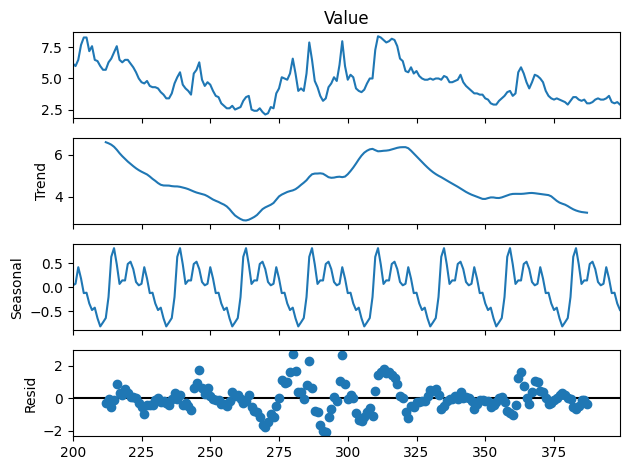

In [9]:
result = seasonal_decompose(combined_df[combined_df['location'] == '1067']['Value'], 
                            model='additive', period=24)
result.plot()
pyplot.show()

### Univariate Timeseries Analysis

Ad Fuller Test:

H0: There's a root unit present in the timeseries(i.e. not stationary)

H1: There's no root unit present in the timeseries(i.e. data is stationary)

If P < critical value(0.05) conclude that H0 is false and data is stationary.


In [10]:
combined_df
results = {}
for city in combined_df.location.drop_duplicates():
    univariate_df = combined_df[combined_df['location'] == city]

    # Checking if data is stationary
    adf_results = adfuller(univariate_df['Value'])

    # Adding test-statistic + P-Value to dict
    results[city] = [round(adf_results[0],3), round(adf_results[1],6)]
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Stistic', 'P-Value'])
results_df.head(10)

,Stistic,P-Value
1064,-2.749,0.065995
1067,-3.032,0.031982
1068,-3.259,0.016804
1069,-3.605,0.005675


### Plotting ACF and PACF
1. Moving Average portion of model(q) depends on ACF test
2. Autoregressive portion of model(p) depends on PACF test


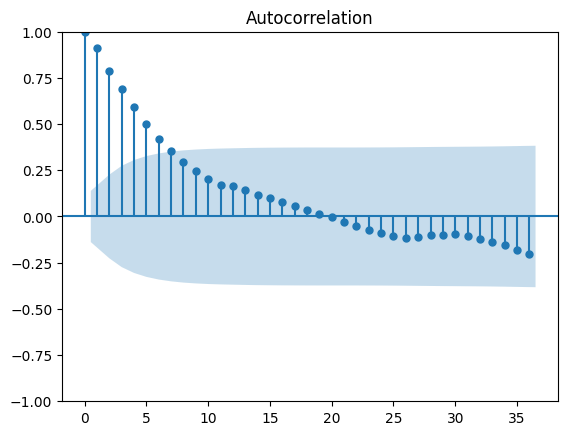

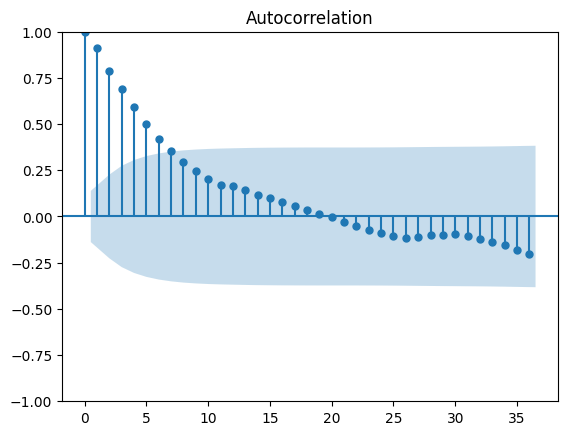

In [11]:
plot_acf(univariate_df['Value'], lags=36)

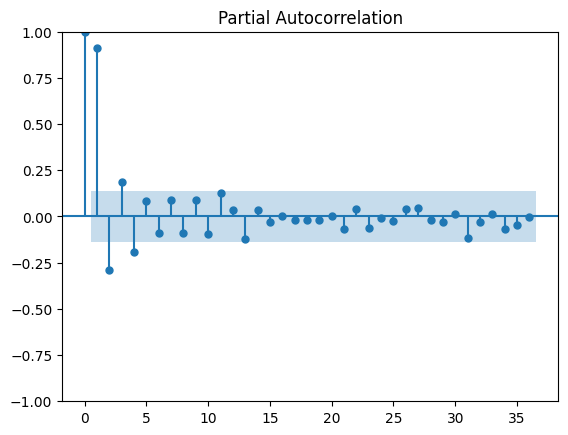

In [12]:
plot_pacf(univariate_df['Value'], lags=36)
pyplot.show()

### Building ARIMA Model

Order is defined as (p,d,q) = (Autoregressive, integration(how many times we difference), Moving Average)

In [13]:
order = (10, 0, 2)
model = ARIMA(univariate_df['Value'], order= order)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [15]:
univariate_df = univariate_df.sort_values(by = 'Date_Converted')

In [16]:
# split into train and test sets
X = univariate_df['Value'].values
# Train - non 2021 months, Test - 2021 months
size = int(len(X) - 24) 
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [17]:
predictions = []
for month in range(len(test)):
    fitting_df = univariate_df['Value'][:len(train)+month]
    model = ARIMA(fitting_df, order= order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    predictions.append(yhat)


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Des

In [18]:
# evaluate forecasts
r2 = r2_score(univariate_df['Value'][-len(predictions):], predictions)
print('Test R2 Score: %.3f' % r2)

Test R2 Score: 0.719


In [20]:
# Melting down comparison dataframe for plotting
actual_df = univariate_df[['Date_Converted', 'Value']]
actual_df['Variable'] = 'Actual'
dates = univariate_df['Date_Converted'][-len(predictions):]
test_dict = {'Date_Converted': dates,
                             'Value': predictions}

predicted_df = pd.DataFrame.from_dict(test_dict)
predicted_df['Variable'] = 'Predicted'
compare_df = pd.concat([actual_df, predicted_df])

C:\Users\seelc\AppData\Local\Temp\ipykernel_48560\3276738924.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# Graphing predictions vs actual values
predictions_fig = px.line(compare_df,x = 'Date_Converted', y = 'Value', color = 'Variable', 
                            title = 'Air Polution Forecasted vs Acual ' + 'R2 Score: '+ str(round(r2,2)))
predictions_fig.show()

### Multivariate Model

First we want to measure the correlation of exogenous variables at offset value t with our response variable. To do this we'll create a helper function to offset our data and measure correlation using a pearson correlation coefficient.

In [23]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

Next we need to reshape our data so each of the values of the locations is a separate column.

### Test Method for Reshaping Data + Dealing Different Dates

In [26]:
def reshape_and_clean(combined_df):

    """ Pivots dataframe so each locations particulate value is
    its own column. Uses backfill interpolation to replace null values.

    Parameters
    ----------
    combined_df : dataframe, contains air particulate data for different locations
    Returns
    ----------
    multivariate_df : dataframe, each location having its own column
    """

    test_df = combined_df.sort_values(by = 'Date_Converted')
    locations = combined_df['location'].drop_duplicates().to_list()
    locations.remove(LOCATION_OF_INTEREST)

    multivariate_df = combined_df[combined_df['location'] == LOCATION_OF_INTEREST].rename(columns={'Value':LOCATION_OF_INTEREST})[['Date', LOCATION_OF_INTEREST]]

    for location in locations:
        subset_df = combined_df[combined_df['location'] == location]
        subset_df = subset_df.rename(columns ={'Value':location})
        subset_df = subset_df[[ 'Date', location]]
        
        multivariate_df = multivariate_df.merge(subset_df, how = 'left', on = 'Date')

    # If a value is NAN will use the previous value in that series to fill it
    for location in locations:
        multivariate_df[location] = multivariate_df[location].ffill()
    multivariate_df.head(10)

    return multivariate_df

In [27]:
multivariate_df = reshape_and_clean(combined_df)
multivariate_df.head(10)

,Date,1067,1064,1068,1069
0,2024-08-02T17:00:00+00:00,6.2,5.6,5.2,5.5
1,2024-08-02T16:00:00+00:00,6.0,5.2,4.9,5.5
2,2024-08-02T15:00:00+00:00,6.5,5.1,4.7,5.6
3,2024-08-02T14:00:00+00:00,7.7,4.9,4.6,5.5
4,2024-08-02T13:00:00+00:00,8.3,4.6,4.3,5.4
5,2024-08-02T12:00:00+00:00,8.3,4.4,4.2,5.4
6,2024-08-02T11:00:00+00:00,7.2,4.1,4.0,5.1
7,2024-08-02T10:00:00+00:00,7.6,3.9,3.8,4.8
8,2024-08-02T09:00:00+00:00,6.5,3.9,3.1,4.6
9,2024-08-02T08:00:00+00:00,6.4,3.9,3.1,4.6


In [28]:
# Creating list of x_vars and dropping date
x_vars = multivariate_df.columns.to_list()[1:]
# Saving response variable
response_var = multivariate_df.columns.to_list()[1]
# Dropping response variable form x_vars
corr_matrix = []
x_vars = x_vars[1:]
lags = range(1,6)
for var in x_vars:
    var_cor = []
    for lag in lags:
        var_cor.append(round(crosscorr(multivariate_df[response_var], multivariate_df[var], lag = lag),2))
    corr_matrix.append(var_cor)

In [29]:
print(lags)
fig = px.imshow(corr_matrix,
                labels=dict(x="Lag", y="Variable", color="Pearson Correlation"),
                x=[i for i in lags],
                y=x_vars,
                text_auto=True,
                title= "Variable Correlation Exogenous variables"
               )
fig.show()

range(1, 6)


assembling and standardizing multivariate dataframe

In [30]:
exogenous_vars = ['1069']
dependent = ['1067']
total_vars = exogenous_vars + dependent

multivariate_df = multivariate_df[['Date'] + exogenous_vars + dependent]
multivariate_df.head(10)

,Date,1069,1067
0,2024-08-02T17:00:00+00:00,5.5,6.2
1,2024-08-02T16:00:00+00:00,5.5,6.0
2,2024-08-02T15:00:00+00:00,5.6,6.5
3,2024-08-02T14:00:00+00:00,5.5,7.7
4,2024-08-02T13:00:00+00:00,5.4,8.3
5,2024-08-02T12:00:00+00:00,5.4,8.3
6,2024-08-02T11:00:00+00:00,5.1,7.2
7,2024-08-02T10:00:00+00:00,4.8,7.6
8,2024-08-02T09:00:00+00:00,4.6,6.5
9,2024-08-02T08:00:00+00:00,4.6,6.4


### Forecasting multiple Timeseries with ARIMA

Can train and Arima model on each timeseries independently and then forecast each timeseries with that model

In [32]:
training_len = int(len(multivariate_df) * 0.8)
# Setting p and q
p = 10
q = 2

def stepforward_prediction(p, q, multivariate_df, vars):
    
    multivariate_df = multivariate_df.sort_values(by = 'Date', ascending=True)
    training_len = int(len(multivariate_df) * 0.8)
    test_multivariate = multivariate_df[training_len:]
    # Iterating through variables
    predictions_arima = []
    for step in range(len(test_multivariate)):
        # Making and storing predictions
        observation = []
        for var in vars:

            fitting_df = multivariate_df[var][:training_len+step]
            model =  ARIMA(fitting_df, order = (p, 0, q), trend='n' )
            model_fit = model.fit()
            output = model_fit.forecast().values
            observation.append(output[0])
        predictions_arima.append(observation)

    # Converting Prediction to Dataframe
    output_dict = {}
    for i in range(len(vars)):
        output_dict[vars[i]] = [row[i] for row in predictions_arima]

    output_dict['Date'] = test_multivariate['Date'].sort_values(ascending=False)
    output_df = pd.DataFrame.from_dict(output_dict)
    output_df['Category'] = 'Predicted'
    return output_df

arima_pred = stepforward_prediction(p, q, multivariate_df, total_vars)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Des

LinAlgError: LU decomposition error.

In [ ]:
concatted_df_arima = concat_predictions(multivariate_df, arima_pred)
concatted_df_arima.head(10)


,Date,1069,1067,Category
0,2024-08-02T17:00:00+00:00,5.5,6.2,Actual
1,2024-08-02T16:00:00+00:00,5.5,6.0,Actual
2,2024-08-02T15:00:00+00:00,5.6,6.5,Actual
3,2024-08-02T14:00:00+00:00,5.5,7.7,Actual
4,2024-08-02T13:00:00+00:00,5.4,8.3,Actual
5,2024-08-02T12:00:00+00:00,5.4,8.3,Actual
6,2024-08-02T11:00:00+00:00,5.1,7.2,Actual
7,2024-08-02T10:00:00+00:00,4.8,7.6,Actual
8,2024-08-02T09:00:00+00:00,4.6,6.5,Actual
9,2024-08-02T08:00:00+00:00,4.6,6.4,Actual


In [ ]:
graph_forecast(concatted_df_arima, "ARIMA")

### Forecasting multiple Timeseries with SARIMAX

Can train and Sarimax model on each timeseries independently using the other timeseries as exogenous variables.

In [38]:
import warnings
warnings.simplefilter("ignore")

# Setting p and q
p = 10
q = 2

P = 1
Q = 0


def stepforward_prediction_sarimax(p, q, P, Q, multivariate_df, vars):
    count = 0
    multivariate_df = multivariate_df.sort_values(by = 'Date', ascending=True)
    training_len = int(len(multivariate_df) * 0.8)
    test_multivariate = multivariate_df[training_len:]
    # Iterating through variables
    predictions_arima = []

    for step in range(len(test_multivariate)):
        # Making and storing predictions
        observation = []
        for var in vars:

            fitting_df = multivariate_df[var][:training_len+step]
            exog = vars.copy()
            exog.remove(var)
            exog_df = multivariate_df[exog[0]][:training_len+step]
            print(count)
            count += 1
            #print(exog_df)
            #print(fitting_df)

            model =  SARIMAX(endog = fitting_df,
                             exog = exog_df,
                             order = (p, 0, q),
                             seasonal_order = (P, 0, Q, 24) )
            model_fit = model.fit()
            #output = model_fit.forecast(steps = 1)
            output = model_fit.get_prediction(exog=exog_df)
            prediction = output.predicted_mean.iloc[-1:]

            observation.append(prediction.values[0])
        predictions_arima.append(observation)

    # Converting Prediction to Dataframe
    output_dict = {}
    for i in range(len(vars)):
        output_dict[vars[i]] = [row[i] for row in predictions_arima]

    output_dict['Date'] = test_multivariate['Date'].sort_values(ascending=True)
    output_df = pd.DataFrame.from_dict(output_dict)
    output_df['Category'] = 'Predicted'
    return output_df

sarimax_pred = stepforward_prediction_sarimax(p, q, P, Q, multivariate_df, ['1069', '1067'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [41]:
concatted_df_sarimax = concat_predictions(multivariate_df, sarimax_pred)
concatted_df_sarimax[concatted_df_sarimax['Category'] == 'Predicted'].head(10)



,Date,1069,1067,Category
200,2024-08-01T02:00:00+00:00,4.266607,4.204473,Predicted
201,2024-08-01T03:00:00+00:00,4.027950,4.529170,Predicted
202,2024-08-01T04:00:00+00:00,4.520701,5.653554,Predicted
203,2024-08-01T05:00:00+00:00,5.268949,4.826550,Predicted
204,2024-08-01T06:00:00+00:00,5.452328,4.550165,Predicted
205,2024-08-01T07:00:00+00:00,5.941276,3.560240,Predicted
206,2024-08-01T08:00:00+00:00,4.639969,3.573314,Predicted
207,2024-08-01T09:00:00+00:00,6.451241,3.467757,Predicted
208,2024-08-01T10:00:00+00:00,6.168526,3.917511,Predicted
209,2024-08-01T11:00:00+00:00,5.404575,3.753926,Predicted


In [44]:
graph_forecast(concatted_df_sarimax, "SARIMAX", total_vars)

### SARIMAX Variable Search, P, D

In [ ]:
def hyperparameter_search(order_list, multivariate_df, vars):

    count = 0
    multivariate_df = multivariate_df.sort_values(by = 'Date', ascending=True)
    training_len = int(len(multivariate_df) * 0.95)

    # Iterating through variables
    results = []
    for order in tqdm(order_list):
            
        if True:
            fitting_df = multivariate_df[vars[0]][:training_len]
            exog = vars.copy()
            exog.remove(var)
            exog_df = multivariate_df[exog[0]][:training_len]
            print(count)
            count += 1

            model =  SARIMAX(endog = fitting_df,
                                exog = exog_df,
                                order = (order[0], 0, order[1]),
                                seasonal_order = (order[2], 0, order[3], 24) )
            model_fit = model.fit()

            aic = model_fit.aic
            # Storring results
            results.append([order, aic])
        else:
            print("ran into error")
            continue
    # Converting Prediction to Dataframe
    results_df = pd.DataFrame(results)
    results_df.columns = ['(p,q,P,Q)', 'AIC']
    # sorting results
    results_df = results_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return results_df

# Seasonal variables
p = [10]
q = [2]
P = range(0, 4, 1)
Q = range(0, 4, 1)

parameters = product(p,q,P,Q)
#parameter_list = [1,2,1,1]
parameter_list = list(parameters)

# calling function
aic_compare = hyperparameter_search(parameter_list, multivariate_df, total_vars)
aic_compare

  0%|          | 0/16 [00:00<?, ?it/s]

0


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Des

1


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



2


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



3


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Chec

4


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Des

5


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



6


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



7


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Chec

8


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



9


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



10


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



11


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Chec

12


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



13


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



14


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



15


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Chec

,"(p,q,P,Q)",AIC
0,"(10, 2, 0, 0)",562.018794
1,"(10, 2, 1, 0)",563.378028
2,"(10, 2, 0, 1)",563.632981
3,"(10, 2, 0, 2)",565.422317
4,"(10, 2, 1, 1)",565.876501
5,"(10, 2, 2, 0)",565.916383
6,"(10, 2, 0, 3)",566.312566
7,"(10, 2, 2, 1)",566.449931
8,"(10, 2, 3, 0)",566.799016
9,"(10, 2, 1, 3)",567.943468


### MultiVariate Timeseries Forecasting with VARMA()

Process:
1. Check if variables are stationary, if not difference
2. If so determine (p,q) variables for best model
3. Perform Granger Causality test to determine if variables are related at optimal lag identified in step 2
4. Fit best model


In [ ]:
# Checking if data is stationary
stationary_multivariate = {}
vars = exogenous_vars + dependent
for i in vars:

    adf_results = adfuller(multivariate_df[i])
    print("Var: ", i, ", P-value: ", round(adf_results[1],6))

# Based on this can conclude that both variables are stationary, dont need to difference


Var:  1069 , P-value:  0.005675
Var:  1067 , P-value:  0.031982


Now defining function to determine best values of p, q

In [ ]:
def optimize_VARMA(df, max_lag):

    results = []
    for p in tqdm(range(max_lag)):
        for q in tqdm(range(max_lag)):

            try:
                model = VARMAX(df, order = (p, q)).fit()
            except:
                continue

            aic = model.aic
            results.append([p, q, aic])

    # Creating Dataframe from results
    results_df = pd.DataFrame(results)
    results_df.columns = ['p', 'q', 'AIC']

    # Sorting and returning dataframe
    results_df = results_df.sort_values(by = 'AIC', ascending=True).reset_index()
    return results_df

In [ ]:
train = False
if train:
    # Using an 80/20 test train split
    training_len = int(len(multivariate_df) * 0.8)

    # Creating test and train sets
    train_multivariate = multivariate_df[:training_len]
    test_multivariate = multivariate_df[training_len:]


    # Training models
    results_df = optimize_VARMA(train_multivariate[vars], 6)
    results_df.head(10)
else:
    print('No Training today')

No Training today


### Training Best Model

In [48]:
def stepforward_prediction_varma(multivariate_df, train_fraction, p, q, vars):

    count = 0
    training_len = int(len(multivariate_df) * 0.8)
    # Ensuring data is sorted by date Ascending
    multivariate_df = multivariate_df.sort_values(by = 'Date', ascending=True)
    
    # Creating test and train sets
    train_multivariate = multivariate_df[:training_len]
    test_multivariate = multivariate_df[training_len:]
    
    # For storring predictions
    predictions = []
    for step in range(len(test_multivariate)):

        fitting_df = multivariate_df[vars][:len(train_multivariate)+step]
        model =  VARMAX(fitting_df, order = (p, q), trend='n' )
        model_fit = model.fit()
        output = model_fit.forecast().values
        yhat = list(output[0])
        predictions.append(yhat)
        print(count)
        count += 1

    # Converting Prediction to Dataframe
    output_dict = {}
    for i in range(len(vars)):
        output_dict[vars[i]] = [row[i] for row in varma_pred]

    output_dict['Date'] = test_multivariate['Date'].sort_values(ascending=True)
    output_df = pd.DataFrame.from_dict(output_dict)
    output_df['Category'] = 'Predicted'

    return output_df

def concat_predictions(actual_df, predicted_df):

    '''Takes base dataframe + lists containing predicted dates and values
    and returns a merged dataset with a predicted/actual column. Dataframe
    can be used for visualization'''
    
    multivariate_compare = actual_df
    multivariate_compare['Category'] = 'Actual'
    multivariate_compare = pd.concat([multivariate_compare, predicted_df], ignore_index=True)

    return multivariate_compare


def graph_forecast(concatted_df_varma, model_name, vars):

    """
    Takes input dataframe of predicted versus actual values, calculates MAPE score,
    and graphs predicted versus actual
    """

    fig = go.Figure()
    count = 0
    for var in vars:
        fig.add_trace(go.Scatter(x=concatted_df_varma[concatted_df_varma['Category'] == 'Predicted']['Date'], 
                                    y=concatted_df_varma[concatted_df_varma['Category'] == 'Predicted'][var],
                                    line =  dict( width=4, color = DEFAULT_PLOTLY_COLORS[count]),
                                    name='{} {}'.format(var, 'Predicted')))
        fig.add_trace(go.Scatter(x=concatted_df_varma[concatted_df_varma['Category'] == 'Actual']['Date'], 
                                    y=concatted_df_varma[concatted_df_varma['Category'] == 'Actual'][var],
                                    line =  dict( width=4,dash='dash', color = DEFAULT_PLOTLY_COLORS[count]),
                                    name='{} {}'.format(var, 'Actual')))
        count += 1

    # Now scoring predictions using MAPE
    first_date = concatted_df_varma[concatted_df_varma['Category'] == 'Predicted']['Date'].min()
    score_df = concatted_df_varma[concatted_df_varma['Date'] >= first_date].sort_values(by = 'Date', ascending = True)

    scores = []
    for i in vars:
        model_score = round(mean_absolute_percentage_error(score_df[score_df['Category'] == 'Actual'][var], 
                                                        score_df[score_df['Category'] == 'Predicted'][var]),3)
        scores.append(model_score)

    avg_model_score = round(sum(scores)/len(scores),3)

    # Adding model score to fig
    fig.update_layout(title='{} - Predicted versus Actual, MAPE: {}'.format(model_name, avg_model_score),
                    yaxis_zeroline=False, xaxis_zeroline=False)
    fig.show()


    

In [49]:
#best_q = results_df['q'][0]
#best_p = results_df['p'][0]

varma_pred = stepforward_prediction_varma(multivariate_df, 0.8, 10, 2, total_vars)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [54]:
# Converting Prediction to Dataframe
output_dict = {}
for i in range(len(total_vars)):
    output_dict[total_vars[i]] = [row[i] for row in varma_pred]

output_dict['Date'] = test_multivariate['Date'].sort_values(ascending=True)
output_df = pd.DataFrame.from_dict(output_dict)
output_df['Category'] = 'Predicted'


In [55]:
concatted_df_varma = concat_predictions(multivariate_df, output_df)
concatted_df_varma.head(10)

,Date,1069,1067,Category
0,2024-08-02T17:00:00+00:00,5.5,6.2,Actual
1,2024-08-02T16:00:00+00:00,5.5,6.0,Actual
2,2024-08-02T15:00:00+00:00,5.6,6.5,Actual
3,2024-08-02T14:00:00+00:00,5.5,7.7,Actual
4,2024-08-02T13:00:00+00:00,5.4,8.3,Actual
5,2024-08-02T12:00:00+00:00,5.4,8.3,Actual
6,2024-08-02T11:00:00+00:00,5.1,7.2,Actual
7,2024-08-02T10:00:00+00:00,4.8,7.6,Actual
8,2024-08-02T09:00:00+00:00,4.6,6.5,Actual
9,2024-08-02T08:00:00+00:00,4.6,6.4,Actual


### Measuring VARMA Performance

In [57]:
graph_forecast(concatted_df_varma, "VARMA", total_vars)